# Transforming the data for basic machine learning

The dataset I made contains a row for each week and for each user. It defines how many tweets a user produces in that particular week and other metadata about the content.

This data needs to be transformed into the correct form for training the model – the target attribute and N weeks of data as input.

## All weeks

Let's start by making a dataset that will use all user's weeks for training. This means that the last week's number of tweets will be used as the target (active/inactive) and all the remaining tweets will be used for training. For now, I will only used the numeric attributes for training – `tweets`, `total_length`, and `total_words`. They are probably very correlated so I might use just one of them.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
%%time
data = pd.read_csv('../data/data.csv')

CPU times: user 56.3 s, sys: 5.97 s, total: 1min 2s
Wall time: 1min 2s


Select only the columns we are interested in.

In [3]:
transformed = data[['week', 'user', 'tweets', 'total_length', 'total_words']]

Transform the week timestamp into a week number.

In [4]:
transformed['week'] = transformed['week'].apply(lambda w: datetime.strptime(w, '%Y-%m-%d 00:00:00').isocalendar()[1])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [5]:
transformed.head()

,week,user,tweets,total_length,total_words
0,36,bdogg,2,133,24
1,25,0,1,134,24
2,30,00000000,1,77,10
3,32,00000000,1,28,5
4,35,00000000,1,68,12


In [6]:
transformed['week'].min()

23

In [7]:
transformed['week'].max()

43

Now we need to transform the data into a pivot table. Rows will be the user names and columns will be the weeks.

In [8]:
pivot = transformed.pivot_table(index='user', columns='week', values='tweets', aggfunc=np.sum, fill_value=0)

In [9]:
pivot.head()

week,23,24,25,26,27,28,29,30,31,32,33,34,35,36,43
user,,,,,,,,,,,,,,,
bdogg,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
00000000,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0
000000000000111,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
000000000101010,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


Looks like there's a gap between 36th and 43th week. Are there any tweets in the 43th week?

In [10]:
pivot[pivot[43] > 0].shape

(4135, 15)

Yes. Nevertheless, we will drop that week because of the gap in the dataset.

In [11]:
pivot = pivot.drop(43, 1)

Now let's rename the last week to `target`. We'll also change it to a boolean – `active`/`inactive` because we want to train a classification model, not a regression.

In [12]:
pivot = pivot.rename(columns={36: 'target'})

In [13]:
pivot['target'] = pivot['target'] > 0

In [14]:
pivot.head()

week,23,24,25,26,27,28,29,30,31,32,33,34,35,target
user,,,,,,,,,,,,,,
bdogg,0,0,0,0,0,0,0,0,0,0,0,0,0,True
0,0,0,1,0,0,0,0,0,0,0,0,0,0,False
00000000,0,0,0,0,0,0,0,1,0,1,0,0,1,True
000000000000111,0,0,0,0,0,0,0,0,0,0,1,0,0,False
000000000101010,0,0,0,0,0,0,0,0,0,1,0,0,0,False


In [18]:
pivot.shape

(8261680, 14)

## Visualizations

Let's visualize the pivot table we made to understand it more. There may also be mistakes we need to clear.

In [15]:
%matplotlib inline
import matplotlib as plt
import seaborn as sb

sb.set_style('dark')
plt.rcParams['figure.figsize'] = (14,10)

In [25]:
sample = pivot.sample(10)

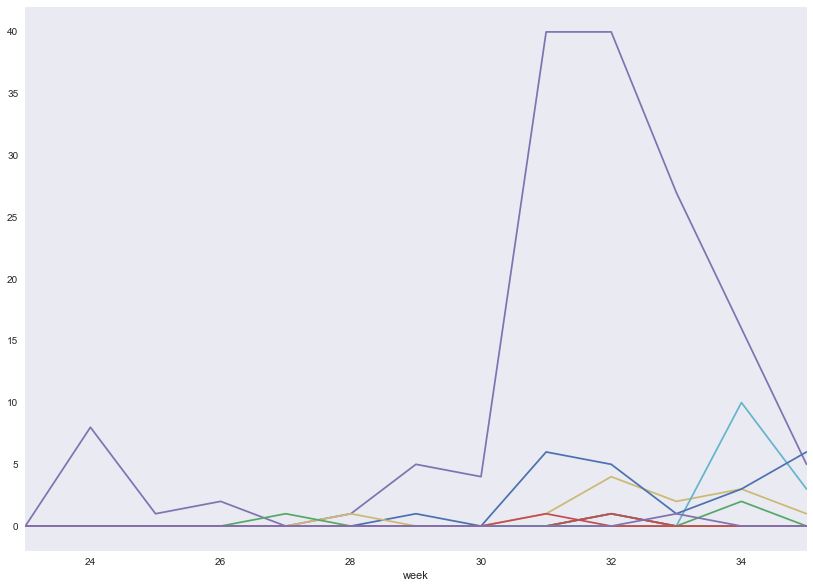

In [33]:
sample.transpose().drop('target').plot(legend=False)

This plot shows a sample of users – the number of their tweets per week.

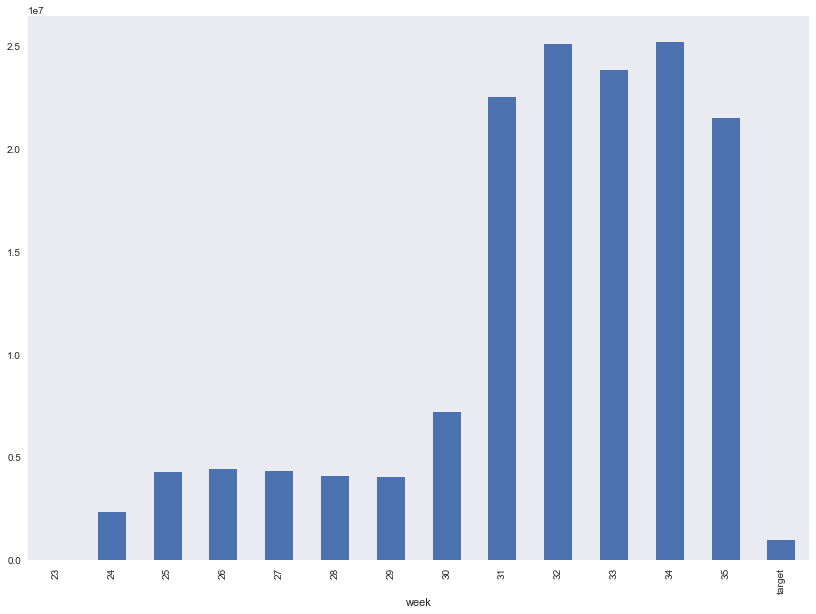

In [34]:
pivot.sum().plot(kind='bar')

The plot above shows the total number of tweets per week. We can see that users in the dataset are far more active after week 29 than before it.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10fc71b38>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11248ef60>]], dtype=object)

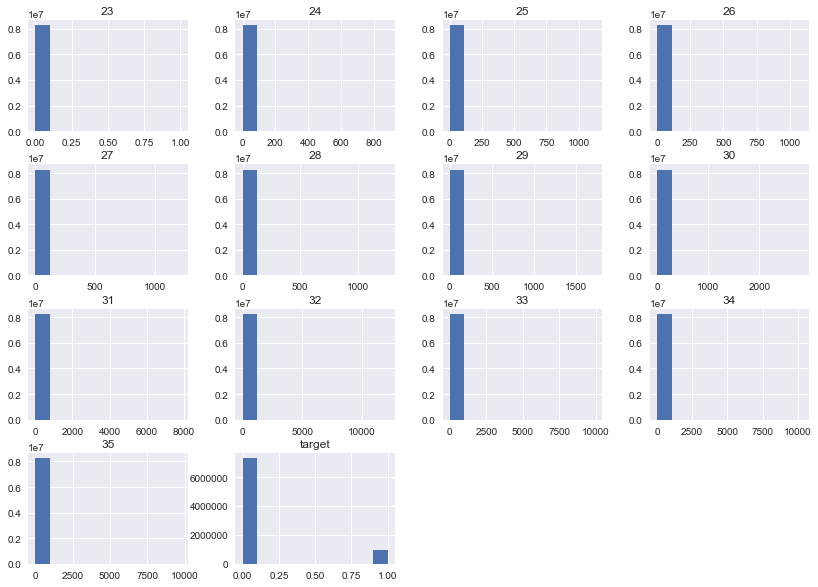

In [35]:
pivot.hist()

The histogram looks boring – most users have 0 or just a couple of tweets per week, which makes the histograms scewed right.

## Training

It's time to train a very basic logistic regression based on the data we made.

In [36]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report

The target value has been transformed into `True`/`False`. Before training the model, we need to split the dataset into train and test sets.

In [37]:
train_rows = np.random.rand(pivot.shape[0]) < 0.7
train = pivot[train_rows]
test = pivot[~train_rows]

In [38]:
%%time
reg = LogisticRegressionCV()
model = reg.fit(train.drop('target', axis=1), train['target'])

CPU times: user 1min 36s, sys: 18.9 s, total: 1min 55s
Wall time: 1min 35s


In [39]:
%%time
predicted = model.predict(test.drop('target', axis=1))

CPU times: user 237 ms, sys: 208 ms, total: 445 ms
Wall time: 396 ms


In [40]:
print(classification_report(test['target'], predicted))

             precision    recall  f1-score   support

      False       0.91      0.99      0.95   2190653
       True       0.77      0.24      0.36    286690

avg / total       0.89      0.90      0.88   2477343



Finally, just a quick check that the model is not simply outputting a single value for each data point.

In [41]:
predicted = model.predict(test.drop('target', axis=1))
unique, counts = np.unique(predicted, return_counts=True)

In [42]:
unique

array([False,  True], dtype=bool)

In [43]:
counts

array([2388104,   89239])